In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Load and normalize **CIFAR10**

In [44]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


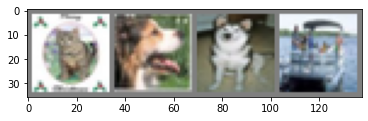

  cat   dog   dog  ship


In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# Define a Convolutional Neural Network

In [4]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [20]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# Define a Loss function and optimizer

In [22]:
criterion = nn.CrossEntropyLoss(reduction='sum')

# Train the network

Main Result. We now introduce our main result. We define the cost function over parameters ω as
C(ω) = (1/N)
PN
j=1 Cj (ω), which is the mean of the per-example costs Cj (ω), where N denotes
the training set size. Gradient flow follows the ODE ω˙ = −∇C(ω), while gradient descent computes
discrete updates ωi+1 = ωi − ∇C(ωi), where  is the learning rate. For simplicity, we assume that
the batch size B perfectly splits the training set such that N%B = 0, where % denotes the modulo
operation, and for convenience we define the number of batches per epoch m = N/B. We can
therefore re-write the cost function as a sum over minibatches C(ω) = (1/m)
Pm−1
k=0 Cˆ
k(ω), where
the minibatch cost Cˆ
k(ω) = (1/B)
PkB+B
j=kB+1 Cj (ω). In order to guarantee that we sample each
example precisely once per epoch, we define SGD by the discrete update ωi+1 = ωi−∇Cˆ
i%m(ωi).
Informally, our main result is as follows. After one epoch, the mean iterate of SGD with a small but
finite learning rate , averaged over all possible shuffles of the batch indices, stays close to the path
of gradient flow on a modified loss ω˙ = −∇CeSGD(ω), where the modified loss CSGD is given by:
CSGD(ω) = C(ω) + 
4m
Xm−1
k=0
||∇Cˆ
k(ω)||2
. (1)

In [51]:
lr = 1e-3
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        m = len(trainloader) / inputs.shape[0]
        loss = criterion(outputs, labels)
        
        
        ck = loss / inputs.shape[0]

        ck.backward(retain_graph=True)
        gradSum = 0
        with torch.no_grad():
          for p in net.parameters():
            gradSum += torch.norm(p.grad)
            
        cw = loss / m
        csgd = cw + ((lr/ (4*m)) * gradSum)
        csgd.retain_grad()
        
        csgd.backward()

        with torch.no_grad():
          for p in net.parameters():
            p -= p.grad * lr

          net.zero_grad()

        running_loss += csgd.item()

    print("running loss: ", running_loss / len(trainloader))


print('Finished Training')

running loss:  0.4121491968241113
running loss:  0.27748418059152413
running loss:  0.23632131927096478
running loss:  0.21215900032521437
running loss:  0.19493296572639632
running loss:  0.1815620927911852
running loss:  0.1703843105357507
running loss:  0.16106731377784972
running loss:  0.15282300519197226
running loss:  0.14531416294600843
Finished Training


In [52]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 50000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 50000 test images: 99 %


# Test the network on the test data

In [11]:
dataiter = iter(testloader)

In [53]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 60 %
